# Importing the necessary libraries and tools

In [ ]:
# Import statements
import json
import pandas as pd
import spacy
import numpy as np
import gym
import tensorflow as tf
import copy
import random
import pylab
import os
import gzip
from urllib.request import urlopen
from collections import deque
from keras import layers, models
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
!pip install wandb -qU

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00


In [ ]:
import wandb
wandb.login()

/usr/local/lib/python3.10/dist-packages/notebook/utils.py:280: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Loading and Exploring the Data

We start by loading the dataset using Python’s **`gzip`** library and examining its structure.

The dataset comprises a list of JSON records, each representing a customer review.

In [ ]:
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/AMAZON_FASHION.json.gz

# Load JSON data
data = []
with gzip.open('AMAZON_FASHION.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
# Let's take a peek at the first row and the total number of rows
print(len(data))
print(data[0])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


--2024-03-25 00:53:57--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/AMAZON_FASHION.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93185167 (89M) [application/x-gzip]
Saving to: ‘AMAZON_FASHION.json.gz’

AMAZON_FASHION.json 100%[===================>]  88.87M  18.5MB/s    in 4.8s    

2024-03-25 00:54:03 (18.5 MB/s) - ‘AMAZON_FASHION.json.gz’ saved [93185167/93185167]

883636
{'overall': 5.0, 'verified': True, 'reviewTime': '10 20, 2014', 'reviewerID': 'A1D4G1SNUZWQOT', 'asin': '7106116521', 'reviewerName': 'Tracy', 'reviewText': 'Exactly what I needed.', 'summary': 'perfect replacements!!', 'unixReviewTime': 1413763200}


# Data Preprocessing and Reduction

**Filtering Verified Reviews**

We filter out reviews that are not verified and have null overall ratings. This ensures that our recommendations are based on trustworthy data.

In [ ]:
# Create a DataFrame for easier data manipulation
df = pd.DataFrame(data)
df = df[['overall','verified','reviewerID','asin','style','reviewerName','reviewText', 'summary','reviewTime']]
# Filter verified reviews with non-null overall ratings
filtered_df = df[(df['verified'] == True) & (~df['overall'].isnull())]
filtered_df.head()

,overall,verified,reviewerID,asin,style,reviewerName,reviewText,summary,reviewTime
0,5.0,True,A1D4G1SNUZWQOT,7106116521,NaN,Tracy,Exactly what I needed.,perfect replacements!!,"10 20, 2014"
1,2.0,True,A3DDWDH9PX2YX2,7106116521,NaN,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...","09 28, 2014"
3,2.0,True,A2UH2QQ275NV45,7106116521,NaN,Jodi Stoner,too tiny an opening,Two Stars,"08 24, 2014"
5,5.0,True,A29HLOUW0NS0EH,7106116521,NaN,Patricia R. Erwin,Exactly what I wanted.,Five Stars,"07 19, 2014"
6,4.0,True,A7QS961ROI6E0,7106116521,NaN,REBECCA S LAYTON,These little plastic backs work great. No mor...,Works great!,"05 31, 2014"


**User and Product Selection**

We focus on users who have purchased more than ten products.

Users with fewer purchases may not provide sufficient data for meaningful recommendations.

In [ ]:
#Create FashionProduct class for a product representation from reviews
class FashionProduct() : pass
class Reviewer() : pass
# Group reviews by reviewers and select users with more than ten purchases
reviewers = {}
grouped_df_reviwerId = filtered_df.groupby('reviewerID')
for reviewerId, group in grouped_df_reviwerId:
    products = group[group['asin'].notna()]['asin'].unique()
    if len(products) > 10:
        reviewer = Reviewer()
        reviewer.reviewerId = reviewerId
        reviewer.products = products
        reviewers[reviewerId] = reviewer

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Dataset Size Reduction**

We reduce the dataset size by removing data from reviewers who have fewer than or equal to ten products.

This helps streamline the dataset and focus on active users.

In [ ]:
# Filter dataset to include only reviewers with more than ten products
filtered_df = filtered_df[(filtered_df['reviewerID'].isin([reviewer for reviewer in reviewers]))]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


**Grouping Reviews**

We group reviews by product ASIN, reviewerID, and review time, ensuring that the data is organized for sequential recommendation tasks.

In [ ]:
# Group reviews by product ASIN, reviewerID, and reviewTime
filtered_df['reviewTime'] = pd.to_datetime(filtered_df['reviewTime'])
filtered_df.sort_values('reviewTime')
grouped_df = filtered_df.groupby(['asin', 'reviewerID', 'reviewTime'], sort=False)

<ipython-input-8-29f449e8e44e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['reviewTime'] = pd.to_datetime(filtered_df['reviewTime'])


**Creating Product States**

We create product states to represent each product’s features and user interactions.

These states store metadata, sizes, colors, and reviews.

In [ ]:
#load spacy for nlp related noun extraction, stopword removal and others
nlp = spacy.load('en_core_web_sm')

# extract nouns from review text
def extract_nouns(doc):
    return " ".join([token.text for token in doc if token.pos_ == "NOUN" or token.pos_ == "PROPN"])

# Initialize a dictionary to store product features as states
states = {}
products = {}

# Iterate over each product
for (product_asin, reviewerId, reviewTime), group in grouped_df:
    if (product_asin, reviewerId) in states: continue
    product = FashionProduct()
    product.product_asin = product_asin
    product.reviewerId = reviewerId
    product.time = reviewTime
    if product_asin not in products:
        products[product_asin] = product
        p= products[product_asin]
        p.reviewers = set()
        p.sizes = set()
        p.colors = set()
        p.reviews = set()
        p.rating =[]

    product.reviewers = products[product_asin].reviewers



    # extract size and color metadata from style column
    styles=  group[group['style'].notna()]['style']
    sizes = styles.apply(lambda x: x.get("Size:", "") if "Size:" in x else x.get("Size Name:", "")).unique().tolist()
    colors = styles.apply(lambda x: x.get("Color:", "")).unique().tolist()

    products[product_asin].sizes.update(sizes)
    products[product_asin].colors.update(colors)

    #extract other noun metadata from review text
    reviews = group[group['reviewText'].notna()]['reviewText']
    reviews = " ".join(reviews.apply(lambda x: " ".join([extract_nouns(chunk) for chunk in nlp(x).noun_chunks]).strip()).unique())
    products[product_asin].reviews.update(reviews)
    #using rms instead of average for review ratings to give slightly higher weightage to good reviews
    ratings = group[group['overall']>0]['overall'].tolist()
    products[product_asin].rating.extend(ratings)
    product.ratings = np.sqrt(np.mean( [r**2 for r in products[product_asin].rating]))

    sizes = " ".join(products[product_asin].sizes)
    colors = " ".join(products[product_asin].colors)
    reviews = " ".join(products[product_asin].reviews)
    product.metadata= " ".join((reviews+" "+sizes+" "+colors).split())

    # add past product and reviewer's product metadata
    # we will take metatdata of last 2 reviewer only as large metadata causes memory issues
    for reviewer in list(product.reviewers)[-2:]:
        state = states[(product_asin, reviewer)]
        product.metadata += " "+state.metadata

    # keep past reviewer list
    products[product_asin].reviewers.add(reviewerId)

    states[(product_asin, reviewerId)] = product

states_list= list(states.values())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Enhanced State Metadata**

We enhance state metadata by combining it with metadata from previous products reviewed by the same user and previous products reviewed by the same product other reviewers.

In [ ]:
# Add past product and reviewer's product metadata to the current state

#for reviewer in list(product.reviewers)[-2:]:
#    state = states[(product_asin, reviewer)]
#   product.metadata += " " + state.metadata

users={}
# Create states for users and enhance metadata with past products
for state in states_list:
    if state.reviewerId not in users:
        users[state.reviewerId] = Reviewer()
        users[state.reviewerId].products = set()
    for prod1 in list(users[state.reviewerId].products)[-2:]:
        state1 = states[(prod1, state.reviewerId)]
        state.metadata += state1.metadata

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Eliminating Empty Metadata**

Finally, we remove states with empty metadata, ensuring that our states contain valuable information for recommendations.

In [ ]:
# Remove states with empty metadata
states_list = [s for s in states_list if s.metadata.strip() != '']

# Creating the environment using Open AI gym

In [ ]:
# Create Product Recommendation env
class RecommendationEnv(gym.Env):
    def __init__(self, states, states_dict, iterations = 10):
        self.states = states
        self.state = self.states[0]
        self.states_dict = states_dict
        self.iterations = iterations
        self.index = 0
        state.action = 0

    def step(self, actions):
        # Implement the transition logic based on the action
        reward= 0
        done= False
        reviewerId= self.state.reviewerId
        future_asins= [p for p in reviewers[reviewerId].products if self.states_dict[(p,reviewerId)].time>self.state.time]
        matched_recommendations = False
        #predicted recommendations
        for i in actions:
          if self.states[i].product_asin in future_asins:
            self.action = i
            matched_recommendations = True
            break;


        if matched_recommendations:
            #Higher reward as they are bought products for the user in future
            reward = 1
        else:
            self.action = actions[0]


        self.index += 1
        self.state = self.states[self.index]
        print(f"iteration :{self.index}")
        if (self.iterations == self.index): done = True

        return self.state, reward, done, {}

    def reset(self, iterations = 10):
        # Reset the state to the initial position
        self.state = self.states[0]
        self.iterations = iterations
        self.index = 0
        return self.state

# Create the custom environment
env = RecommendationEnv(states_list, states, 10)

# Implementing DQN Agent

In [ ]:
# Implementation of DQN algorithm
class DQNAgent:
    def __init__(self, state_size, action_size, states):
        self.states = states
        self.state_size = state_size
        self.action_size = action_size

        # These are hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()
        self.target_model = self.build_model()

        # initialize target model
        self.update_target_model()

    # approximate Q function using Neural Network
    # state is input and Q Value of each action is output of network
    def build_model(self):
        #Using RNN as it is recommended for text classification
        # Using the TextVectorization layer to normalize, split, and map strings
        # to integers.

        encoder = tf.keras.layers.TextVectorization(max_tokens=10000)
        metadatas = [product.metadata for product in self.states]
        ratings = [product.ratings for product in self.states]
        encoder.adapt(metadatas)

        model = tf.keras.Sequential([
            encoder,
            layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
            layers.Bidirectional(layers.LSTM(64,  return_sequences=True)),
            layers.Bidirectional(tf.keras.layers.LSTM(32)),
            layers.Dense(64, activation='relu')
        ])
        # Create an input layer for ratings
        ratings_input = tf.keras.layers.Input(shape=(1,), name='ratings_input')

        # Concatenate the output of the previous layers with ratings
        concatenated = layers.concatenate([model.output, ratings_input])

        # Add additional layers for your desired architecture
        dense_layer = layers.Dense(64, activation='relu')(concatenated)
         # One Q-value per action
        output_layer = layers.Dense(len(self.states), activation='linear')(dense_layer)

        # Create the final model with both metadata and ratings as inputs
        model = tf.keras.Model(inputs=[model.input, ratings_input], outputs=output_layer)
        # Summary of the model
        model.summary()

        # Compile the model
        optimizer=tf.keras.optimizers.Adam(config.lr)
        model.compile(optimizer=config.optimizer, loss=config.loss_function)

        return model

    # after some time interval update the target model to be same with model
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # get recommendations from model using epsilon-greedy policy
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.sample(range(self.action_size),10)
        else:
            q_value = self.model.predict([np.array([state.metadata]), np.array([state.ratings])])
            return np.argpartition(q_value[0],-10)[-10:]

    # save sample <s,a,r,s'> to the replay memory
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    # pick samples randomly from replay memory (with batch_size)
    def train_model(self):
        if len(self.memory) < self.train_start:
            return
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)

        update_input_metadata =[]
        update_input_ratings =[]
        update_target_metadata = []
        update_target_ratings = []
        action, reward, done = [], [], []

        for i in range(self.batch_size):
            update_input_metadata.append(np.array(mini_batch[i][0].metadata))
            update_input_ratings.append(np.array(mini_batch[i][0].ratings))
            action.append(mini_batch[i][1])
            reward.append(mini_batch[i][2])
            update_target_metadata.append(np.array(mini_batch[i][3].metadata))
            update_target_ratings.append(np.array(mini_batch[i][3].ratings))
            done.append(mini_batch[i][4])

        target = self.model.predict([np.transpose(update_input_metadata),np.transpose(update_input_ratings)])
        target_val = self.target_model.predict([np.transpose(update_target_metadata),np.transpose(update_target_ratings)])

        for i in range(self.batch_size):
            # Q Learning: get maximum Q value at s' from target model
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + self.discount_factor * ( np.amax(target_val[i]))

        # and do the model fit!
        self.model.fit([np.transpose(update_input_metadata),np.transpose(update_input_ratings)], target, batch_size=config.batch_size,
                       epochs=config.epochs, verbose=1,callbacks=[WandbCallback()])

state_size = len(env.states)
# Every other product can be a recommendation
action_size = state_size
run=wandb.init(project="Recommender system",
               config={
                    "epochs":1,
                    "batch_size":64,
                    "loss_function":"mse",
                    "lr":0.001,
                    "architecture":"LSTM",
                    "optimizer":"adam"
                }
        )
config=wandb.config
agent = DQNAgent(state_size, action_size, env.states)

wandb: Currently logged in as: vishnu2002. Use `wandb login --relogin` to force relogin


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_vectorization_input (  [(None,)]                    0         []                            
 InputLayer)                                                                                      
                                                                                                  
 text_vectorization (TextVe  (None, None)                 0         ['text_vectorization_input[0][
 ctorization)                                                       0]']                          
                                                                                                  
 embedding (Embedding)       (None, None, 64)             14848     ['text_vectorization[0][0]']  
                                                                                              

Displaying the set of Product ID's recommended for a random reviewer selected from the environment's states.

In [ ]:
import random

# Select a random reviewer from the environment's states
random_reviewer = random.choice(env.states).reviewerId

# Get recommendations for the random reviewer from the agent
recommended_products = agent.get_action(random_reviewer)

# Print the recommended product IDs
print("Recommended Products for Reviewer", random_reviewer, ":", recommended_products)

Recommended Products for Reviewer A3E3O468TGBYRP : [1002, 435, 247, 316, 927, 321, 1355, 1033, 102, 523]


# Running the algorithm

In [ ]:
from wandb.keras import WandbCallback

iteration :1
iteration :2
iteration :3
iteration :4
iteration :5
iteration :6
iteration :7
iteration :8
iteration :9
iteration :10
iteration :11
iteration :12
iteration :13
iteration :14
iteration :15
iteration :16
iteration :17
1/1 [==============================] - 5s 5s/step
iteration :18
iteration :19
iteration :20
iteration :21
iteration :22
iteration :23
iteration :24
iteration :25
iteration :26
iteration :27
iteration :28
iteration :29
iteration :30
iteration :31
iteration :32
iteration :33
iteration :34
iteration :35
iteration :36
iteration :37
iteration :38
iteration :39
iteration :40
iteration :41
iteration :42
iteration :43
iteration :44
iteration :45
iteration :46
iteration :47
iteration :48
iteration :49
iteration :50
iteration :1
iteration :2
iteration :3
iteration :4
iteration :5
iteration :6
iteration :7
iteration :8
iteration :9
iteration :10
iteration :11
iteration :12
iteration :13
iteration :14
iteration :15
iteration :17
1/1 [==============================] - 0s 25

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


1/1 [==============================] - 0s 26ms/step
iteration :1
1/1 [==============================] - 0s 27ms/step
iteration :2
1/1 [==============================] - 0s 411ms/step - loss: 7.8811e-04
iteration :3
1/1 [==============================] - 0s 45ms/step
iteration :4
1/1 [==============================] - 0s 26ms/step
iteration :5
1/1 [==============================] - 0s 423ms/step - loss: 7.7360e-04
iteration :6
1/1 [==============================] - 0s 26ms/step
iteration :9
1/1 [==============================] - 0s 32ms/step
iteration :10
1/1 [==============================] - 0s 39ms/step
iteration :11
1/1 [==============================] - 0s 27ms/step
iteration :12
1/1 [==============================] - 0s 25ms/step
iteration :13
1/1 [==============================] - 0s 28ms/step
iteration :14
1/1 [==============================] - 0s 42ms/step
iteration :15
1/1 [==============================] - 0s 29ms/step
iteration :23
1/1 [==============================] - 0s 2

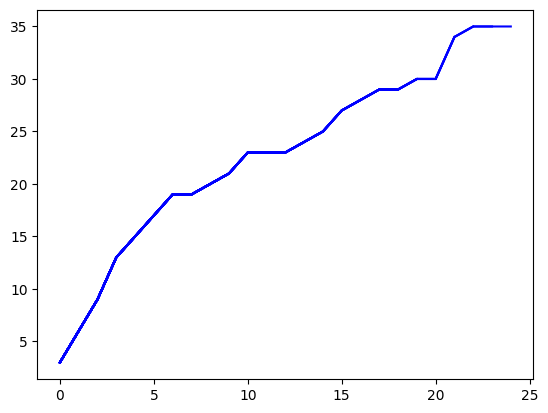

In [ ]:
import numpy as np

def ndcg(relevance_list, k):
    # Discount factors for each rank position
    ranks = np.arange(1, k + 1)
    discounts = 1 / np.log2(ranks + 1)

    # Sort the relevance list in descending order
    sorted_relevance = sorted(relevance_list, reverse=True)

    # Compute Discounted Cumulative Gain (DCG)
    dcg = np.sum(sorted_relevance[:k] / discounts)

    # Compute Ideal Discounted Cumulative Gain (IDCG)
    ideal_sorted_relevance = sorted([1] * len(relevance_list), reverse=True)  # Ideal ranking with relevance=1
    idcg = np.sum(ideal_sorted_relevance[:k] / discounts)

    # Compute NDCG
    if idcg == 0:
        return 0  # Handle division by zero
    else:
        ndcg_score = dcg / idcg
        return ndcg_score

# Initialize a dictionary to store NDCG scores for each episode
ndcg_scores = {}

scores, episodes = [], []
EPISODES = 25
# Cache already rewarded recommendations (optimization done based upon context and to improve the performance to a large extent)
next_states = {}
done_value = {}
action_value = {}
user_history = []

for e in range(EPISODES):
    done = False
    score = 0
    state = env.reset(50)
    user_history_episode = []
    relevance_list = []  # Relevance list for the current episode

    while not done:
        if (state.product_asin, state.reviewerId) in next_states:
            next_state = next_states[(state.product_asin, state.reviewerId)]
            reward = 1
            done = done_value[(state.product_asin, state.reviewerId)]
            action = action_value[(state.product_asin, state.reviewerId)]
            env.index += 1
        else:
            # Get action for the current state and go one step in the environment
            actions = agent.get_action(state)
            next_state, reward, done, info = env.step(actions)
            action = env.action
            if (reward == 1):
                next_states[(state.product_asin, state.reviewerId)] = next_state
                done_value[(state.product_asin, state.reviewerId)] = done
                action_value[(state.product_asin, state.reviewerId)] = env.action

        # Save the sample <s, a, r, s'> to the replay memory
        agent.append_sample(state, action, reward, next_state, done)

        # Append the current state to the user's interaction history for this episode
        user_history_episode.append(state)

        # Append the reward to the relevance list
        relevance_list.append(reward)

        # Every time step, do the training
        agent.train_model()
        score += reward
        state = next_state

        if done:
            # Every episode update the target model to be the same with the model
            agent.update_target_model()

            # Append the episode's user history to the global user history
            user_history.extend(user_history_episode)

            # Compute the NDCG score for this episode's relevance list
            k = len(relevance_list)  # Set k to the length of relevance list
            ndcg_score = ndcg(relevance_list, k)

            # Store the NDCG score in the dictionary
            ndcg_scores[e] = ndcg_score

            scores.append(score)
            episodes.append(e)
            pylab.plot(episodes, scores, 'b')

    if (score > 48):
        break

# Metrics

Novelty Score

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def calculate_novelty(agent, user_history):
    recommended_items = []
    for state in user_history:
        # Get recommendations from the agent
        recommendations = agent.get_action(state)
        recommended_items.append(recommendations)

    # Convert the lists to 2D arrays
    recommended_items = np.array(recommended_items)

    # Reshape the array to ensure it is 2D
    recommended_items = recommended_items.reshape(-1, recommended_items.shape[1])

    # Calculate similarity matrix between recommended items
    similarity_matrix = cosine_similarity(recommended_items)

    # Calculate novelty as the average dissimilarity between recommended items
    novelty_score = 1 - similarity_matrix.mean()

    print(recommended_items)
    return novelty_score

# `agent` is an instance of the DQNAgent class and
# `user_history` is a list of states representing the user's historical interactions
novelty = calculate_novelty(agent, user_history)
print("Novelty Score:", novelty)

1/1 [==============================] - 0s 26ms/step
[[  43  644 1006 ... 1155 1041 1003]
 [  43  644 1006 ...  155 1213  761]
 [  43  644 1006 ...  155 1213  761]
 ...
 [ 683  638  615 ... 1068  882   42]
 [  43 1006 1041 ...  761 1003 1046]
 [ 644   43 1006 ... 1213 1003  155]]
Novelty Score: 0.15370204983040525


NDCG (Normalized Discounted Cumulative Gain) Score

In [ ]:
# Print the NDCG scores after all episodes are completed
for episode, ndcg_score in ndcg_scores.items():
    print("NDCG Score for episode", episode, ":", ndcg_score)

NDCG Score for episode 0 : 0.02085205908929913
NDCG Score for episode 1 : 0.055935858212723594
NDCG Score for episode 2 : 0.09910408076644836
NDCG Score for episode 3 : 0.16528632322648865
NDCG Score for episode 4 : 0.20124625744325048
NDCG Score for episode 5 : 0.23880022635619252
NDCG Score for episode 6 : 0.27777527478975583
NDCG Score for episode 7 : 0.27777527478975583
NDCG Score for episode 8 : 0.29775119878571765
NDCG Score for episode 9 : 0.3180323530158532
NDCG Score for episode 10 : 0.35945722620929604
NDCG Score for episode 11 : 0.35945722620929604
NDCG Score for episode 12 : 0.35945722620929604
NDCG Score for episode 13 : 0.3805771292959973
NDCG Score for episode 14 : 0.40195436994582817
NDCG Score for episode 15 : 0.44544271778394007
NDCG Score for episode 16 : 0.4675364441228488
NDCG Score for episode 17 : 0.48985260758727445
NDCG Score for episode 18 : 0.48985260758727445
NDCG Score for episode 19 : 0.5123839138276038
NDCG Score for episode 20 : 0.5123839138276038
NDCG S

Serendipity

In [ ]:
# Initialize variables for serendipity calculation
serendipity_count = 0
total_recommendations = 0

for (product_asin, reviewerId) in next_states:
    # Check if the recommended product is not in the user's history
    if (product_asin, reviewerId) not in [(state.product_asin, state.reviewerId) for state in user_history]:
        serendipity_count += 1

    total_recommendations += 1

# Calculate serendipity as the ratio of unexpected recommendations to total recommendations
serendipity = serendipity_count / total_recommendations

print("Serendipity:", serendipity)

Serendipity: 0.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Precision

In [ ]:
# Initialize variables for precision calculation
relevant_recommendations = 0
total_recommendations = 0

# Loop through the recommended products
for (product_asin, reviewerId) in next_states:
    # Check if the recommended product is in the user's history
    if (product_asin, reviewerId) in [(state.product_asin, state.reviewerId) for state in user_history]:
        relevant_recommendations += 1

    total_recommendations += 1

# Calculate precision as the ratio of relevant recommendations to total recommendations
precision = relevant_recommendations / total_recommendations

print("Precision:", precision)

Precision: 1.0
